# Lesson 1
In this lesson we will build an image classifier using fastai. We will classify images of cats and dogs into their breeds. Note to the worried: I will use import * from fastai.vision and .metrics because this notebook is for exploration and learning about different methods available for us, as the fastai course says. I would not do this in production code.

In [46]:
import numpy as np
from fastai.vision import *
from fastai.metrics import *

Use the built-in data gathering resources to download example pictures of dogs and cats from the course. We will also create a folder for images and annotations. Annotations in this context are not actually used, but I will create it because the example I'm running does. Maybe we'll use it later.

In [5]:
path = untar_data(URLs.PETS)
path_img = path/'images'
path_anno = path/'annotations'
path.ls()

[PosixPath('/storage/oxford-iiit-pet/images'),
 PosixPath('/storage/oxford-iiit-pet/annotations')]

Use built in fastai method for saving a list of the image file names and print the first 5 to get an idea of what we're storing. We will use these labels to check how well our image classifier works.

In [10]:
fnames = get_image_files(path_img)

for i in list(range(len(fnames[:5]))):
    print(fnames[i])

/storage/oxford-iiit-pet/images/miniature_pinscher_166.jpg
/storage/oxford-iiit-pet/images/american_bulldog_180.jpg
/storage/oxford-iiit-pet/images/keeshond_167.jpg
/storage/oxford-iiit-pet/images/Siamese_28.jpg
/storage/oxford-iiit-pet/images/english_cocker_spaniel_163.jpg


In [12]:
# set the random seed for consistency on subsequent runs
np.random.seed(2)

bs = 64 # batch size. Change to something smaller if we run into processing problems

pat = r'/([^/]+)_\d+.jpg$' # set formatting for the fastai method for gathering the data from images

In [13]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

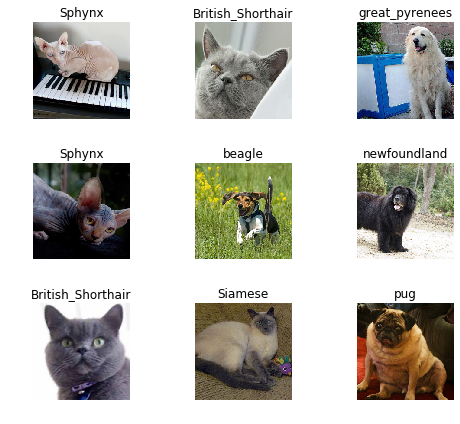

In [14]:
data.show_batch(rows=3, figsize=(7,6))

Just to see what we're working with, let's print all the possible classes

In [15]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


Let's take our first pass at training on the data. We will use a convolutional neural network with a resnet34 model, which is a residual neural network with 34 layers.

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Now we'll learn using the 1cycle technique, pioneered by Leslie Smith, which performs a training cycle with a monotonically increasing learning rate for half of the iterations, followed by a monotonically decreasing learning rate for the second half, finally with a tail to a very low learning rate at the end. Heuristically, Smith finds that the iterations with the high learning rate prevents overfitting, while the low learning rate in the later iterations allows the network to find the minimum of the loss function more accurately. We will learn for 4 epochs and then save our model as 'stage-1'.

In [22]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,0.295827,0.247853,0.081191,00:24
1,0.365374,0.246342,0.077808,00:23
2,0.290815,0.200742,0.063599,00:23
3,0.213552,0.191815,0.066982,00:23


Now that we've taken a first pass at training our model, let's look at our results, and specifically which breeds the model classified incorrectly most often. We will plot the 9 breeds that were misidentified the most with their predicted breed, actual breed, loss, and probability of actual class. We will also plot the confusion matrix and print a list of all the breeds that were misidentified more than twice.

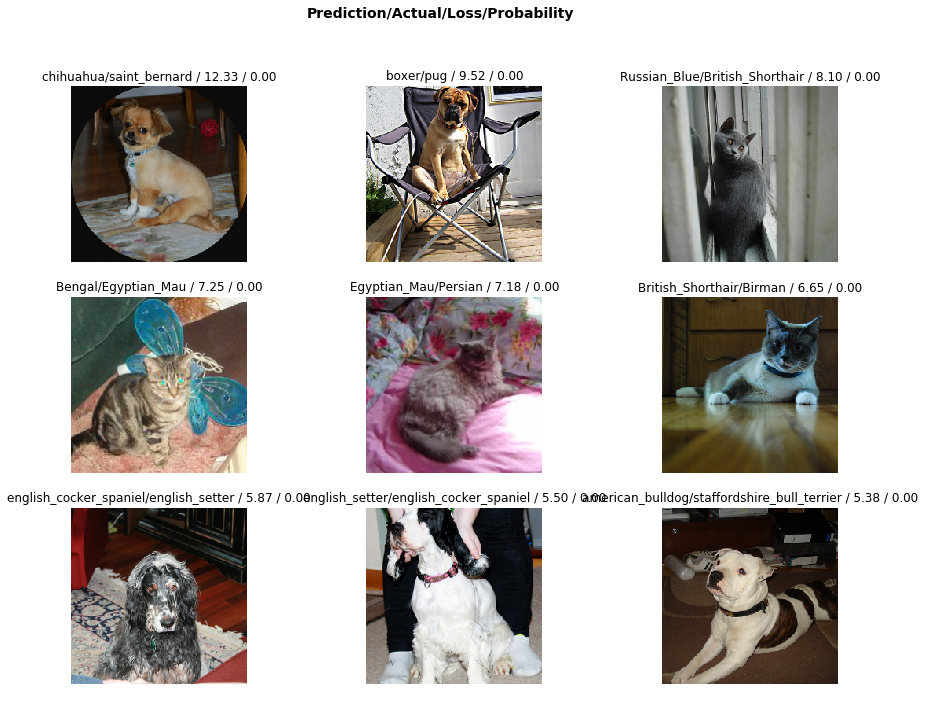

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [39]:
doc(interp.plot_top_losses)

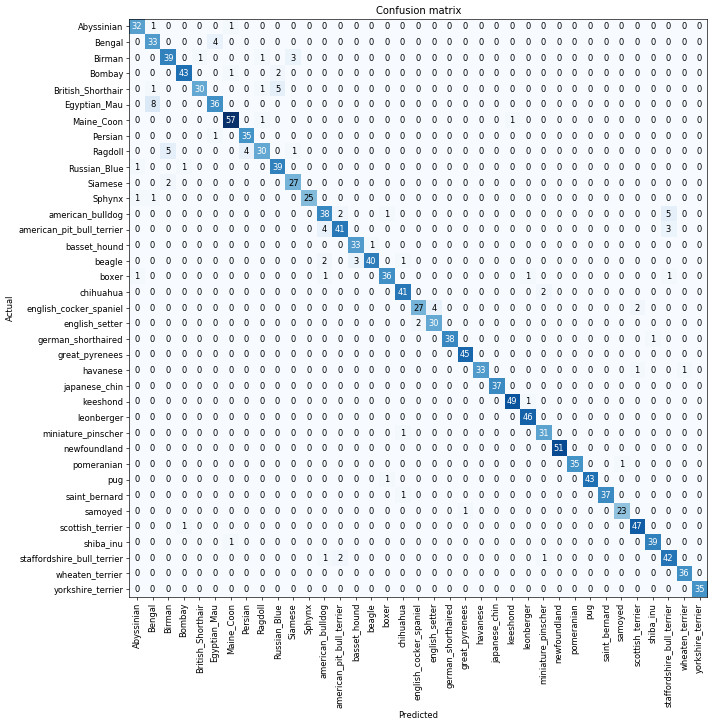

In [40]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [46]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('Birman', 'Siamese', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('boxer', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Bombay', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Maine_Coon', 'Abyssinian', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Persian', 'Ragdoll', 2),
 ('Siamese', 'Birman', 2),
 ('Sphynx', 'chihuahua', 2),
 ('basset_hound', 'english_cocker_spaniel', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('newfoundland', 'english_cocker_spaniel', 2),
 ('pug', 'boxer', 2),
 ('shiba_inu', 'samoyed', 2)]

# Unfreezing, fine tuning, and learning rates
Now that we have confirmed on a quick test run that the model is working as we would expect we will unfreeze the model and train more to see if we can make any accuracy improvements. Namely, we will see if we can improve the learning rate. First let's refit with only one epoch.

In [41]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.697407,0.334711,0.100135,00:32


In [45]:
doc(learn.unfreeze)

In [44]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.602360,0.354245,0.111637,00:27


In [42]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
miniature_pinscher,american_bulldog,keeshond,samoyed,Maine_Coon
Path: /storage/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
staffordshire_bull_terrier,Bombay,basset_hound,pug,Russian_Blue
Path: /storage/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [50]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


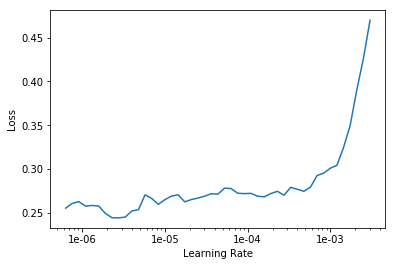

In [51]:
learn.recorder.plot()

In [52]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.241545,0.201293,0.069689,00:28
1,0.212424,0.198497,0.069012,00:27


In [57]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [58]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


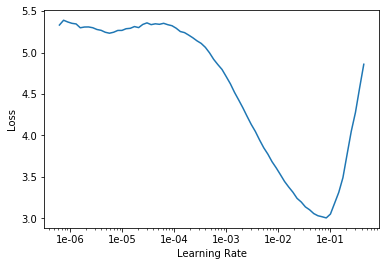

In [59]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.744660,0.311929,0.096076,01:13
1,0.525863,0.304377,0.093369,01:12
2,0.452303,0.276197,0.084574,01:12
3,0.328783,0.254481,0.081867,01:13
4,0.275142,0.195510,0.058863,01:13
5,0.179963,0.187672,0.052774,01:13


In [ ]:
learn.save('stage-1-50')